# Questions Clustering - English

## Expected
Questions to be sorted out such that the response to the whole cluster is same.

<!--### To Do-->
Author: Sunanda Bansal  
Organization: Dataperformers  
License: CC BY-NC  
Date: 24 Mar, 2020 (Start)  

In [1]:
import re
import regex
import os
import csv
import sys
import json
import time
import scipy
import socket
import pickle
import numpy as np
import pandas as pd
import multiprocessing as mp

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer   
from sklearn import metrics   
from sklearn.metrics import confusion_matrix
# from sklearn.metrics.pairwise import paired_distances as sklearn_paired_distances

# Plotting
import seaborn as sn
import matplotlib.pyplot as plt

# importing personal development helper classes
import utils

Using TensorFlow backend.


## Define variables here

Mostly the code will be intended to use with arguments that can be passed in comman line, but jupyter notebook doesn't handle `argparse` well, so the Args class is a temporary way to write the code assumming the variables to be an attribute of an object.

In [2]:
class Args:
    def __init__(self):
        # The very big scraped file, give absolute path, outside the repo
        # self.filename = "query_result_2020-03-27T19_12_30.866993Z.csv"
        self.filename = "covid_questions_2020-04-21.csv"
        
        # path to the file
        self.dataset = f"data/{self.filename}"    
        
        # suffix used to create
        self.suffix = "_".join([word for word in self.filename.split("_") if not word.isalpha()])[:-4]
        self.vector_mode = "tfidf"
        self.n_topics = 230
        self.dist_thresh = 1.5
        self.lang = "en"
args=Args()

In [3]:
# Disable (FALSE) displaying warnings from the OpenMP* run-time library during program execution.
os.environ['KMP_WARNINGS'] = "FALSE"

## Functions

In [4]:
# Regex functions
def surrounding(word,area=2):
    # A funtion, yet to be defined, that can be used to extract text around keywords
    return

def fuzzy_match(word,pattern):
    '''
        Fuzzy matching function to be used with .apply() of pandas

        Reason - Fuzzy matching is available in regex package, not in re package, 
        therefore fuzzy matching is not a part of pandas string matching functions
    '''
 
    if regex.search(pattern, word, re.IGNORECASE):
        return True
    else:
        return False    
    
# Language Detection
from langdetect import detect
def detect_lang(text):
    # Used to detect language of the question
    try:
        return detect(text)
    except:
        return "unidentifiable"   

### Natural Lanuage Proprocessing Functions
   
Preprocessing done -
   1. Normalizing accents  
   2. Removing non alphabetic characters  
   3. Casefolding  

Preprocessing not done -
   1. Stopword removal - For questions, stopwords are essential and thus are retained
   2. Stemming - For rule based analysis it might be useful to keep the words as they are, for LSA, the questions don't have enough variation in content to benefit for stemming

In [5]:
import re
import nltk
import unidecode

# Regular expression to select all that is not alphabet
# @maybe allow numbers as well
alpha_regex = re.compile('[^a-zA-Z]')

from nltk.corpus import stopwords as sw
if args.lang == "en": stopwords = sw.words('english')
if args.lang == "fr": stopwords = sw.words('french')

from nltk.stem.snowball import SnowballStemmer
if args.lang == "en": stemmer = SnowballStemmer("english")
if args.lang == "fr": stemmer = SnowballStemmer("french")

def tokenize(text):
    '''
        1. Normalized accents
        2. Splits at non alpbhaetic character (@maybe need to revisit for french text)
        3. Caasefolds
    '''    
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            # Handle french accents in text
            word = unidecode.unidecode(word)
            
            # Split at every non alphabet character occurrence
            clean_words = alpha_regex.sub(' ', word).split()
            
            # Casefold
            tokens.extend([word.lower() for word in clean_words])
    
    # Return tokens
    return tokens

def stem(word):
    return stemmer.stem(word).strip()

def preprocess(text):    
    tokenized = tokenize(text)
    # cleaned = [word for word in tokenized if word not in stopwords and word != '']
    # stemmed = [stem(word) for word in cleaned]
    return ' '.join(tokenized)

## Dataset

In [80]:
# Read dataset
dataset = pd.read_csv(args.dataset)
print(f"Dataset has {len(dataset)} documents")

# Detect Language
dataset["detected_lang"] = dataset.question.apply(detect_lang)

print(f"Dataset has {len(dataset[dataset.detected_lang=='en'])} english documents and {len(dataset[dataset.detected_lang=='fr'])} french documents")
print(f"{len(dataset)-len(dataset[dataset.detected_lang=='en'])-len(dataset[dataset.detected_lang=='fr'])} documents will not be processed because of different language")

Dataset has 5054 documents
Dataset has 2032 english documents and 2733 french documents
289 documents will not be processed because of different language


In [81]:
# Translation Questions from French to English
if "translated_question" not in dataset.columns:
    dataset["translated_question"] = np.nan

translated_df_path = f"data/{os.path.basename(args.filename)[:-4]}_fr.csv"
fr = pd.DataFrame(columns=["question","translated_question"])
if os.path.exists(translated_df_path):
    fr_csv = pd.read_csv(translated_df_path, index_col=0)
    fr = fr.combine_first(fr_csv)
    dataset.update(fr.translated_question)
    
# Any french questions that need to be translated?
fr_questions = dataset[
                        (dataset.detected_lang == "fr") & 
                        (dataset.translated_question.isnull())
                      ][["question","translated_question"]]

if len(fr_questions)>0:    
    try:
        from googletrans import Translator
        translator = Translator()
        translations = []
        for q in list(fr_questions.question):
            translations.append(translator.translate(q).text)
        print("Using google translate.")
    except:
        # HACK for when your IP has been blocked
        translations_file_path = f"data/{os.path.basename(args.filename)[:-4]}_fr_translations.txt"
        if os.path.exists(translations_file_path):   
            # Delete if already exists
            os.remove(translations_file_path)
        
        # Create file and initialize empty
        os.mknod(translations_file_path)      
        translations = []
        
        while (len(translations) != len(fr_questions)):
            print(f"Translate the output french to english using gogle translate and copy this into this file - {translations_file_path} \n{'-'*100}")
            print(*fr_questions.question.tolist(),sep="\n")
            # Translate the output french to english using gogle translate 
            # and copy this into a text file save as {filename}_fr_translated.txt in data folder
            input(f"{'-'*100}\nPress Enter to continue...")
            
            with open(translations_file_path,"r") as f:
                translations = f.read().split("\n")  
            
    fr_questions.translated_question = translations
    dataset.update(fr_questions.translated_question)
    dataset[dataset.detected_lang == "fr"][["question","translated_question"]].to_csv(translated_df_path)

Using google translate.


In [82]:
# Preprocess questions
eng = dataset[dataset.detected_lang == "en"].question.apply(preprocess).to_frame(name="text")
french = dataset[dataset.detected_lang == "fr"].translated_question.apply(preprocess).to_frame(name="text")
dataset["text"] = eng.combine_first(french).dropna()

# Drop
dataset = dataset.dropna(subset=['text'])

print(f"Dataset has {len(dataset)} english documents (translated and otherwise)")

Dataset has 4765 english documents (translated and otherwise)


In [83]:
# dataset[(dataset.language != "en") & (dataset.detected_lang == "en")]

In [84]:
# dataset[(dataset.language == "en") & (dataset.detected_lang != "en")]

### Length analysis for situations

In [85]:
dataset["len"] = dataset.text.apply(lambda x: len(x.split()))

In [86]:
# Set default value
dataset["cluster"] = "unclassified"

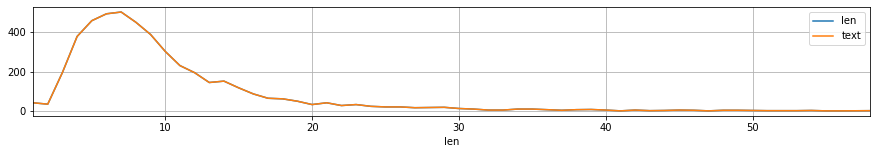

In [87]:
dataset[dataset.len<60].groupby("len")["len","text"].count().plot(figsize=(15,2),grid=True)

## Rules
Note: The order of these rules matters in resolving conflicts

In [88]:
# Separate very long questions out
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (dataset.len > 15)
                , "cluster" ] = "too-much-information"

In [53]:
# # Can be used to check if the keywords are mentioned (optional)
# dataset.loc[                     
#                     (dataset.cluster=="unclassified") & 
#                     (dataset.text.str.contains("(?:corona|covid)",case=False))
#                 , "cluster" 
#             ] = "covid-about"

In [32]:
# Statistics
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("cases",case=False)|
                        dataset.text.str.contains("dea(?:th|d)(?:ly)?",case=False)|
                        dataset.text.str.contains("died",case=False)|
                        dataset.text.str.contains("(?:mortality|death|fatality) rate",case=False)|
                        dataset.text.str.contains("statistic",case=False)|
                        (
                            dataset.text.str.contains("how",case=False)&
                            dataset.text.str.contains("many",case=False)&
                            dataset.text.str.contains("people",case=False)
                        )
                    )
                , "cluster" ] = "situation-stats"

In [33]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (dataset.text.str.contains(r"\b(?:animal|bird|cat|dog|pet)s?\b",case=False))
                , "cluster" ] = "covid-transmission-animals"

In [34]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("mask",case=False)|
                        dataset.text.str.contains("glove",case=False)
                    )
                , "cluster" ] = "covid-precaution-gear"

dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("wash",case=False)
                    )
                , "cluster" ] = "covid-precaution-disinfection"

dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains(r"\bisolat",case=False)|
                        dataset.text.str.contains(r"\bsocial dist",case=False)|
                        dataset.text.str.contains(r"\bconfine",case=False)
                    )
                , "cluster" ] = "covid-precaution-isolation"

In [35]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            (
                                dataset.text.str.contains("go (?:on|to|for|out)",case=False)|
                                dataset.text.str.contains("walk",case=False)
                            )&
                            (
                                dataset.text.str.contains("allow",case=False)|
                                dataset.text.str.contains("can",case=False)|
                                dataset.text.str.contains("ok|okay",case=False)|
                                dataset.text.str.contains("should|shall",case=False)
                            )
                        )|
                        (
                            dataset.text.str.contains("lockdown",case=False)|
                            dataset.text.str.contains(r"\bopen\b",case=False)|
                            dataset.text.str.contains(r"\bclose",case=False)
                        )
                    )
                , "cluster" ] = "situation-lockdown"



In [36]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("if i (?:have|am|m)",case=False)
                    )
                , "cluster" ] = "covid-whatif"

In [37]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains(r"i (?:have|ve)",case=False)|
                        (
                            dataset.text.str.contains(r"\b(?:has|have)",case=False)&
                            dataset.text.str.contains(r"symptom",case=False)
                        )
                        # dataset.text.str.contains(r"(?:i (?:think|feel) )?i \b(?:have|ve|am|m)\b",case=False)
                    )
                , "cluster" ] = "personal-symptoms"

In [39]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains(r"\btransmi|contract|catch|spread|airborne",case=False)
                    )                
                , "cluster" ] = "covid-transmission"

dataset.loc[
                    (dataset.cluster=="covid-transmission") & 
                    (
                        dataset.text.str.contains("again",case=False)|
                        dataset.text.str.contains("twice",case=False)
                    )                
                , "cluster" ] = "covid-transmission-twice"

In [40]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                            (
                                dataset.text.str.contains("(?:corona|covid)",case=False)|
                                dataset.text.str.contains("virus",case=False)
                            )&
                            (
                                dataset.text.str.contains("live|stay|survive",case=False)
                            )&
                            (
                                dataset.text.str.contains("on",case=False)
                            )
                    )
                , "cluster" ] = "covid-life"

In [41]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("infected",case=False)|
                        dataset.text.str.contains("infection",case=False)
                    )                
                , "cluster" ] = "covid-infection"

In [42]:
# dataset.loc[
#                     (dataset.cluster=="unclassified") & 
#                     (
#                         dataset.text.str.contains("prevent",case=False)|
#                         dataset.text.str.contains("protect",case=False)|
#                         dataset.text.str.contains("precaution",case=False)|
#                         dataset.text.str.contains("safety",case=False)|
#                         (
#                             dataset.text.str.contains("keep",case=False)&
#                             dataset.text.str.contains("safe",case=False)
#                         )
#                     )               
#                 , "cluster" ] = "covid-precaution"

In [43]:
# dataset.loc[
#                     (dataset.cluster=="unclassified") & 
#                     (
#                             (
#                                 dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
#                                 dataset.text.str.contains("corona",case=False)|
#                                 dataset.text.str.contains("virus",case=False)
#                             )&
#                             (
#                                 dataset.text.str.contains("kills",case=False)
#                             )
#                     )                
#               , "cluster" ] = "covid-kill"

In [44]:
# dataset.loc[
#                     (dataset.cluster=="unclassified") & 
#                     (
#                             (
#                                 (
#                                     dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
#                                     dataset.text.str.contains("corona",case=False)|
#                                     dataset.text.str.contains("virus",case=False)
#                                 )&
#                                 (
#                                     dataset.text.str.contains("fight",case=False)
#                                 )&
#                                 (
#                                     dataset.text.str.contains("help",case=False)
#                                 )
#                             )|
#                             (
#                                 dataset.text.str.contains("mask",case=False)|
#                                 dataset.text.str.contains("glove",case=False)
#                             )
#                         )                
#                     , "cluster" ] = "covid-fight"

In [45]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("treatment",case=False)|
                        dataset.text.str.contains("cure",case=False)|
                        dataset.text.str.contains("vaccine",case=False)|
                        dataset.text.str.contains("medic",case=False)
                    )                
                , "cluster" ] = "covid-med"

In [46]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("incubate",case=False)|
                        dataset.text.str.contains("incubation",case=False)
                    )      
                , "cluster" ] = "covid-incubation"

In [47]:
# dataset.loc[                     
#                        (dataset.cluster=="unclassified") & (
# #                         dataset.text.str.contains(r"\bgo\b",case=False)&
#                         (
#                             dataset.text.str.contains("hospital",case=False)|                            
#                             dataset.text.str.contains(r"\bER\b",case=False)
#                         )
#                     )
#                , "cluster" ] = "hospital"

In [48]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("diff",case=False)|
                        dataset.text.apply(fuzzy_match, pattern="(?:distinguish){e<=3}")
                    )                
                , "cluster" ] = "covid-versus"

In [49]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("tested",case=False)|
                        dataset.text.str.contains("test",case=False)
                    )                
                , "cluster" ] = "personal-testing"

dataset.loc[
                    (dataset.cluster=="personal-testing") & 
                    (
                        dataset.text.str.contains("(?:tested|test)",case=False) &
                        dataset.text.str.contains("where",case=False)
                    )                
                , "cluster" ] = "personal-testing-location"

In [50]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("recover",case=False)
                    )                
                , "cluster" ] = "covid-recovery"

In [ ]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("at risk",case=False)|
                        (
                            dataset.text.str.contains("more",case=False) &
                            dataset.text.str.contains("risky|dangerous",case=False)
                        )
                    )                
                , "cluster" ] = "covid-vulnerable"

In [51]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("dangerous",case=False)|
                        dataset.text.str.contains("risk",case=False)
                    )                
                , "cluster" ] = "covid-contagious"

In [52]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (dataset.text.str.contains(r"\bsymptom",case=False))                
                , "cluster" ] = "covid-symptoms"

In [53]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            dataset.text.apply(fuzzy_match, pattern="(?:whats|what (?:is|s))")
                        ) & 
                        (
                            dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
                            dataset.text.str.contains("corona",case=False)
                        )
                    )                
                , "cluster" ] = "covid-what"

In [54]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            (
                                dataset.text.str.contains("how",case=False) &
                                dataset.text.str.contains("long",case=False)
                            )|
                            dataset.text.str.contains("when",case=False)
                        )&
                            dataset.text.str.contains("will",case=False)&
                        (
                            dataset.text.str.contains("last|end|over|normal|done",case=False)
                        )
                    )                
                , "cluster" ] = "situation-future"

In [55]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            dataset.text.str.contains("how|when|where",case=False) 
                        )&
                            dataset.text.str.contains("did",case=False)&
                        (
                            dataset.text.str.contains("start|begin|began",case=False)
                        )
                    )                
                , "cluster" ] = "situation-past"

In [56]:
features = dataset.cluster.unique().tolist()

In [57]:
features

['unclassified',
 'covid-precaution-isolation',
 'personal-testing',
 'personal-symptoms',
 'covid-contagious',
 'too-much-information',
 'covid-symptoms',
 'situation-lockdown',
 'covid-versus',
 'covid-whatif',
 'covid-transmission-animals',
 'covid-what',
 'covid-life',
 'situation-future',
 'situation-stats',
 'covid-transmission',
 'personal-testing-location',
 'covid-med',
 'covid-precaution-gear',
 'covid-precaution-disinfection',
 'covid-infection',
 'covid-infection-recovery',
 'covid-incubation',
 'situation-past',
 'covid-transmission-twice']

In [58]:
# Clustering stats
dataset.groupby("cluster")["question"].count()

cluster
covid-contagious                  142
covid-incubation                   28
covid-infection                    97
covid-infection-recovery           21
covid-life                        117
covid-med                         106
covid-precaution-disinfection      47
covid-precaution-gear              70
covid-precaution-isolation         89
covid-symptoms                    454
covid-transmission                169
covid-transmission-animals         56
covid-transmission-twice           14
covid-versus                       44
covid-what                        147
covid-whatif                      168
personal-symptoms                 247
personal-testing                  156
personal-testing-location          43
situation-future                   40
situation-lockdown                161
situation-past                      4
situation-stats                   172
too-much-information              673
unclassified                     1486
Name: question, dtype: int64

In [105]:
# Saving the files
path = f"output/simpleFiltered_{args.suffix}_{args.lang}.csv"
dataset.to_csv(path)
print(f"Rules based output saved to {path}")

Rules based output saved to output/simpleFiltered_2020-04-21_en.csv


## LSA and AHC

In [69]:
'''
    If considering NLTK tokenization of questions
'''
# Combining french translations and english questions in one column
eng = dataset[dataset.detected_lang == "en"].question.to_frame(name="text")
french = dataset[dataset.detected_lang == "fr"].translated_question.to_frame(name="text")
d = eng.combine_first(french).dropna()

# Adding cluster information from rules
d["cluster"] = dataset.cluster

# Adding length as a feature
# d["len"] = dataset.len

# Selecting unclassified questions
d = d[d.cluster=="unclassified"] # May be also cluster too-much-information clusters

# Pre-processing
import nltk

stopwords_list = nltk.corpus.stopwords.words('english')
wn_lemmatizer = nltk.stem.WordNetLemmatizer()

def bulk_tokenizer(texts):
#      return [[wn_lemmatizer.lemmatize(token) for token in nltk.word_tokenize(text)] for text in texts]
     return [nltk.word_tokenize(text) for text in texts]

In [74]:
'''
    If considering the same preprocessing as used for rules above
'''
d = dataset[dataset.cluster=="unclassified"][["text","cluster","question","translated_question"]]

def bulk_tokenizer(texts):
     return [text.split() for text in texts]

In [75]:
d.head()

,text,cluster,question,translated_question
0,what is dialogue s position on sick notes,unclassified,What is Dialogue's position on sick notes?,NaN
1,what are dialogue services,unclassified,What are Dialogue services?,NaN
4,i d love to know how long i can be contagious,unclassified,I'd love to know how long I can be contagious?,NaN
11,is the cough dry or oily,unclassified,Est ce que la toux est sèche ou grasse?,Is the cough dry or oily?
12,i do n t feel well,unclassified,Je ne me sens pas bien,I don't feel well


In [76]:
args.n_topics = 15
args.dist_thresh = 0.8
model = utils.text.representation.LSI(args, tokenizer=bulk_tokenizer)
d["embedding"] = model.generate_embedding(d.text, returnarray=False)

lsa_features = pd.DataFrame(d["embedding"].values.tolist(), index= d.index).to_numpy()

use_len = False
if use_len:
    # Add len to the feature vector
    d[["embedding","len"]].apply(lambda x: x.embedding.append(x.len), axis=1)

    from sklearn import preprocessing

    x = d.embedding.tolist() #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    lsa_features = x_scaled
    
# Cluster
X = lsa_features
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
d["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(d["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
d.groupby("ahc_label")["question"].count().sort_values()

Found 74 clusters


ahc_label
61      2
60      2
55      3
41      3
68      3
64      4
11      4
57      4
40      4
56      5
71      5
30      5
51      6
32      6
25      6
66      6
42      7
29      7
27      7
26      7
44      7
58      7
4       7
17      8
20      8
23      9
33      9
45     10
65     10
70     10
     ... 
69     14
1      16
10     16
54     17
63     17
50     18
59     20
18     21
53     23
36     23
67     25
37     26
47     26
22     27
73     29
3      31
15     33
8      35
35     38
9      40
21     44
43     48
14     50
16     58
0      59
6      60
5      71
2      72
13     73
34    107
Name: question, Length: 74, dtype: int64

In [77]:
d.groupby("ahc_label")["text"].count().describe()

count     74.000000
mean      20.081081
std       20.609718
min        2.000000
25%        7.000000
50%       12.000000
75%       25.750000
max      107.000000
Name: text, dtype: float64

In [79]:
d.text[d.text.str.contains("what should i do",case=False)]

23               what should i do if i work and i am sick
326     my husband comes back from a trip and lives wi...
341                  what should i do if i start coughing
822                      my throat hurts what should i do
911                           if i cough what should i do
1240                                     what should i do
1892         last month i went on a trip what should i do
2068                what should i do if i think i am sick
2715                       i am coughing what should i do
3067    what should i do if a family member is quarant...
3170                  what should i do if i get the virus
3254    what should i do when i come back home after g...
3558                        i m coughing what should i do
3691           i cough but without fever what should i do
3913    i woke up this morning and i am having trouble...
4286                          what should i do if i cough
4764    what should i do with my children if i and my ...
Name: text, dt

In [90]:
import spacy
from spacy import displacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_md")

In [119]:
# for label in d.ahc_label.unique():
for label in d.ahc_label.unique():
    if len(d[d.ahc_label==label]) < 10:
        print(f"\ncluster #{label}, count - {len(d[d.ahc_label==label])}")
        print ("-------------------------------------------")  
        docs = d[d.ahc_label==label].text.tolist()
        print(*docs,sep="\n")
        print ("-------------------------------------------")  
            
        
        for doc in docs:
            if type(doc) == str:
                doc = nlp_en(doc)
                print (doc)
                print ("-------------------------------------------")      
                displacy.render(doc, style='dep')
                for sentence in doc.sents:
#                     for root_child in sentence.root.children:
#                         if root_child.dep_ in ["advmod","aux"]:
#                             tuples.append([token.head.lemma_, root_child.lemma_])    
                    print (f"{token.lemma_} --> {token.head.lemma_}") 
                    for token in sentence:
                        tuples = []
                        if "nsubj" in token.dep_:                    
                            print (f"{token.lemma_} --> {token.head.lemma_}") 
                            for sibling in token.head.children:
                                if sibling.dep_ in ["dobj","acomp"]:
                                    tuples.append([token.lemma_, token.head.lemma_, sibling.lemma_])  
                            for svo in tuples:
                                print(*svo,sep=" --> ") 
    #                         print([child.text for child in token.head.children])
        #                 print ( token.head.text, token.head.lemma_, token.head.tag_, token.head.i, token.dep_, token.i, token.text, token.lemma_, token.tag_, sep="\t")  
                print ("-------------------------------------------")



cluster #25, count - 6
-------------------------------------------
i d love to know how long i can be contagious
am i going to be sick
how long am i infectious for
if someone sneezes how long does the air around them stay contagious
can i be contagious before i know it
how long do i carry the virus before being contagious
-------------------------------------------
i d love to know how long i can be contagious
-------------------------------------------


-PRON- --> be
i --> love
i --> be
i --> be --> contagious
-------------------------------------------
am i going to be sick
-------------------------------------------


contagious --> be
i --> go
-------------------------------------------
how long am i infectious for
-------------------------------------------


sick --> be
i --> be
i --> be --> infectious
-------------------------------------------
if someone sneezes how long does the air around them stay contagious
-------------------------------------------


for --> infectious
someone --> sneeze
air --> stay
air --> stay --> contagious
-------------------------------------------
can i be contagious before i know it
-------------------------------------------


contagious --> stay
i --> be
i --> be --> contagious
i --> know
i --> know --> -PRON-
-------------------------------------------
how long do i carry the virus before being contagious
-------------------------------------------


-PRON- --> know
i --> carry
i --> carry --> virus
-------------------------------------------

cluster #32, count - 6
-------------------------------------------
what should i do if i work and i am sick
am i affected if i cough
what should i do if i think i am sick
i am coughing what should i do
where do i go if i feel i am affected
what do i do if i feel i am affected
-------------------------------------------
what should i do if i work and i am sick
-------------------------------------------


contagious --> be
i --> do
i --> do --> what
i --> work
i --> be
i --> be --> sick
-------------------------------------------
am i affected if i cough
-------------------------------------------


sick --> be
i --> affect
i --> cough
-------------------------------------------
what should i do if i think i am sick
-------------------------------------------


cough --> affect
i --> do
i --> do --> what
i --> think
i --> be
i --> be --> sick
-------------------------------------------
i am coughing what should i do
-------------------------------------------


sick --> be
i --> cough
i --> do
i --> do --> what
-------------------------------------------
where do i go if i feel i am affected
-------------------------------------------


do --> cough
i --> go
i --> feel
i --> affect
-------------------------------------------
what do i do if i feel i am affected
-------------------------------------------


affect --> feel
i --> do
i --> do --> what
i --> feel
i --> affect
-------------------------------------------

cluster #20, count - 8
-------------------------------------------
can we have covid times
can we get covid more than once
can we have the covid without coughing
can we have covid twice
can we die from coronavirus
can we have covid without fever
can we die from it
can we get coronavirus twice
-------------------------------------------
can we have covid times
-------------------------------------------


affect --> feel
-PRON- --> have
-PRON- --> have --> time
-------------------------------------------
can we get covid more than once
-------------------------------------------


time --> have
-PRON- --> get
-PRON- --> get --> covid
-------------------------------------------
can we have the covid without coughing
-------------------------------------------


once --> than
-PRON- --> have
-PRON- --> have --> covid
-------------------------------------------
can we have covid twice
-------------------------------------------


cough --> without
-PRON- --> have
-PRON- --> have --> covid
-------------------------------------------
can we die from coronavirus
-------------------------------------------


twice --> covid
-PRON- --> die
-------------------------------------------
can we have covid without fever
-------------------------------------------


coronavirus --> from
-PRON- --> have
-PRON- --> have --> covid
-------------------------------------------
can we die from it
-------------------------------------------


fever --> without
-PRON- --> die
-------------------------------------------
can we get coronavirus twice
-------------------------------------------


-PRON- --> from
-PRON- --> get
-PRON- --> get --> coronavirus
-------------------------------------------

cluster #4, count - 7
-------------------------------------------
what to do if i cough
if i cough what should i do
what should i do
what if i cough
what should i do if i get the virus
what should i do if i cough
if i cough what do i do
-------------------------------------------
what to do if i cough
-------------------------------------------


twice --> coronavirus
i --> cough
-------------------------------------------
if i cough what should i do
-------------------------------------------


cough --> do
i --> cough
i --> do
i --> do --> what
-------------------------------------------
what should i do
-------------------------------------------


do --> cough
i --> do
i --> do --> what
-------------------------------------------
what if i cough
-------------------------------------------


do --> do
i --> cough
-------------------------------------------
what should i do if i get the virus
-------------------------------------------


cough --> cough
i --> do
i --> do --> what
i --> get
i --> get --> virus
-------------------------------------------
what should i do if i cough
-------------------------------------------


virus --> get
i --> do
i --> do --> what
i --> cough
-------------------------------------------
if i cough what do i do
-------------------------------------------


cough --> do
i --> cough
i --> do
i --> do --> what
-------------------------------------------

cluster #11, count - 4
-------------------------------------------
how contagious is the virus
how long is a person contagious
how long is a person who has the disease contagious
how long is the virus contagious
-------------------------------------------
how contagious is the virus
-------------------------------------------


do --> cough
virus --> be
virus --> be --> contagious
-------------------------------------------
how long is a person contagious
-------------------------------------------


virus --> be
person --> be
person --> be --> long
-------------------------------------------
how long is a person who has the disease contagious
-------------------------------------------


contagious --> person
person --> be
person --> be --> long
who --> have
who --> have --> disease
-------------------------------------------
how long is the virus contagious
-------------------------------------------


contagious --> have
virus --> be
virus --> be --> long
virus --> be --> contagious
-------------------------------------------

cluster #64, count - 4
-------------------------------------------
when should you consult
when should i consult
when should i consult
when should i consult
-------------------------------------------
when should you consult
-------------------------------------------


contagious --> be
-PRON- --> consult
-------------------------------------------
when should i consult
-------------------------------------------


consult --> consult
i --> consult
-------------------------------------------
when should i consult
-------------------------------------------


consult --> consult
i --> consult
-------------------------------------------
when should i consult
-------------------------------------------


consult --> consult
i --> consult
-------------------------------------------

cluster #61, count - 2
-------------------------------------------
how can you get covid
how do you get covid
-------------------------------------------
how can you get covid
-------------------------------------------


consult --> consult
-PRON- --> get
-PRON- --> get --> covid
-------------------------------------------
how do you get covid
-------------------------------------------


covid --> get
-PRON- --> get
-PRON- --> get --> covid
-------------------------------------------

cluster #71, count - 5
-------------------------------------------
what should we do if our child has a runny nose
at what degree do we have a fever
what do we do with children
what should we do if we have fever now
what must we do
-------------------------------------------
what should we do if our child has a runny nose
-------------------------------------------


covid --> get
-PRON- --> do
-PRON- --> do --> what
child --> have
child --> have --> nose
-------------------------------------------
at what degree do we have a fever
-------------------------------------------


nose --> have
-PRON- --> have
-PRON- --> have --> fever
-------------------------------------------
what do we do with children
-------------------------------------------


fever --> have
-PRON- --> do
-PRON- --> do --> what
-------------------------------------------
what should we do if we have fever now
-------------------------------------------


child --> with
-PRON- --> do
-PRON- --> do --> what
-PRON- --> have
-PRON- --> have --> fever
-------------------------------------------
what must we do
-------------------------------------------


now --> have
-PRON- --> do
-PRON- --> do --> what
-------------------------------------------

cluster #58, count - 7
-------------------------------------------
why is the covid so contagious
why the covid and not the covid
why covid
why is called covid
why is the virus called covid
why is it called covid
why is the virus called covid
-------------------------------------------
why is the covid so contagious
-------------------------------------------


do --> do
covid --> be
covid --> be --> contagious
-------------------------------------------
why the covid and not the covid
-------------------------------------------


contagious --> be
-------------------------------------------
why covid
-------------------------------------------


covid --> covid
-------------------------------------------
why is called covid
-------------------------------------------


covid --> covid
-------------------------------------------
why is the virus called covid
-------------------------------------------


covid --> call
virus --> call
-------------------------------------------
why is it called covid
-------------------------------------------


covid --> call
-PRON- --> call
-------------------------------------------
why is the virus called covid
-------------------------------------------


covid --> call
virus --> call
-------------------------------------------

cluster #40, count - 4
-------------------------------------------
what is
what time is it
what is it
what is it about
-------------------------------------------
what is
-------------------------------------------


covid --> call
what --> be
-------------------------------------------
what time is it
-------------------------------------------


be --> be
-PRON- --> be
-------------------------------------------
what is it
-------------------------------------------


-PRON- --> be
-PRON- --> be
-------------------------------------------
what is it about
-------------------------------------------


-PRON- --> be
-PRON- --> be
-------------------------------------------

cluster #42, count - 7
-------------------------------------------
if we have covid how long are we contagious
how long are we contagious when we have covid
how long are we contagious
how long can we be contagious to others if we have coronavirus
when are we contagious
can we be contagious if we are asymptomatic
how long are we contagious when we have the covid
-------------------------------------------
if we have covid how long are we contagious
-------------------------------------------


about --> be
-PRON- --> have
-PRON- --> have --> covid
-PRON- --> be
-PRON- --> be --> long
-PRON- --> be --> contagious
-------------------------------------------
how long are we contagious when we have covid
-------------------------------------------


contagious --> be
-PRON- --> be
-PRON- --> be --> long
-PRON- --> be --> contagious
-PRON- --> have
-PRON- --> have --> covid
-------------------------------------------
how long are we contagious
-------------------------------------------


covid --> have
-PRON- --> be
-PRON- --> be --> long
-PRON- --> be --> contagious
-------------------------------------------
how long can we be contagious to others if we have coronavirus
-------------------------------------------


contagious --> be
-PRON- --> be
-PRON- --> be --> contagious
-PRON- --> have
-PRON- --> have --> coronavirus
-------------------------------------------
when are we contagious
-------------------------------------------


coronavirus --> have
-PRON- --> be
-PRON- --> be --> contagious
-------------------------------------------
can we be contagious if we are asymptomatic
-------------------------------------------


contagious --> be
-PRON- --> be
-PRON- --> be --> contagious
-PRON- --> be
-PRON- --> be --> asymptomatic
-------------------------------------------
how long are we contagious when we have the covid
-------------------------------------------


asymptomatic --> be
-PRON- --> be
-PRON- --> be --> long
-PRON- --> be --> contagious
-PRON- --> have
-PRON- --> have --> covid
-------------------------------------------

cluster #33, count - 9
-------------------------------------------
how long after being asymptomatic are you no longer contagious
is covid more contagious than influenza
where did the contagious woman arrested in limoilou walk
can an asymptomatic patient with covid be contagious after days
is it really very contagious
if someone has covid when is it no longer contagious
it s contagious
are asymptotic people contagious
is covis contagious
-------------------------------------------
how long after being asymptomatic are you no longer contagious
-------------------------------------------


covid --> have
-PRON- --> be
-PRON- --> be --> contagious
-------------------------------------------
is covid more contagious than influenza
-------------------------------------------


contagious --> be
-------------------------------------------
where did the contagious woman arrested in limoilou walk
-------------------------------------------


influenza --> than
woman --> arrest
-------------------------------------------
can an asymptomatic patient with covid be contagious after days
-------------------------------------------


walk --> walk
patient --> be
patient --> be --> contagious
-------------------------------------------
is it really very contagious
-------------------------------------------


day --> after
-PRON- --> be
-PRON- --> be --> contagious
-------------------------------------------
if someone has covid when is it no longer contagious
-------------------------------------------


contagious --> be
someone --> have
someone --> have --> covid
-PRON- --> be
-PRON- --> be --> contagious
-------------------------------------------
it s contagious
-------------------------------------------


contagious --> be
-PRON- --> s
-PRON- --> s --> contagious
-------------------------------------------
are asymptotic people contagious
-------------------------------------------


contagious --> s
-------------------------------------------
is covis contagious
-------------------------------------------


contagious --> people
-------------------------------------------

cluster #55, count - 3
-------------------------------------------
is covid contagious
how contagious is covid
is covid contagious
-------------------------------------------
is covid contagious
-------------------------------------------


contagious --> covi
-------------------------------------------
how contagious is covid
-------------------------------------------


contagious --> be
-------------------------------------------
is covid contagious
-------------------------------------------


covid --> be
-------------------------------------------

cluster #41, count - 3
-------------------------------------------
what is a virus
what is virus
what is the virus
-------------------------------------------
what is a virus
-------------------------------------------


contagious --> be
virus --> be
-------------------------------------------
what is virus
-------------------------------------------


virus --> be
virus --> be
-------------------------------------------
what is the virus
-------------------------------------------


virus --> be
virus --> be
-------------------------------------------

cluster #56, count - 5
-------------------------------------------
how painful will it be if i got the virus
how long will i be sick if i get the virus
am i going to get the virus
if i get the virus and get well am i immune afterwards
if i get sick with this virus will i be immune afterwards
-------------------------------------------
how painful will it be if i got the virus
-------------------------------------------


virus --> be
-PRON- --> be
-PRON- --> be --> painful
i --> get
i --> get --> virus
-------------------------------------------
how long will i be sick if i get the virus
-------------------------------------------


virus --> get
i --> be
i --> be --> sick
i --> get
i --> get --> virus
-------------------------------------------
am i going to get the virus
-------------------------------------------


virus --> get
i --> go
-------------------------------------------
if i get the virus and get well am i immune afterwards
-------------------------------------------


virus --> get
i --> get
i --> get --> virus
i --> be
i --> be --> immune
-------------------------------------------
if i get sick with this virus will i be immune afterwards
-------------------------------------------


afterwards --> be
i --> get
i --> get --> sick
i --> be
i --> be --> immune
-------------------------------------------

cluster #26, count - 7
-------------------------------------------
a have a fever
i do n t have a fever can i still have coronavirus
can you have covid without having a fever
do you have a sore throat
can we have covid if i do n t have a fever
can i get covid without a fever and only have a cough
if you do n t have a fever can you still have covid
-------------------------------------------
a have a fever
-------------------------------------------


afterwards --> be
-------------------------------------------
i do n t have a fever can i still have coronavirus
-------------------------------------------


fever --> have
i --> have
i --> have --> fever
t --> have
t --> have --> fever
i --> have
i --> have --> coronavirus
-------------------------------------------
can you have covid without having a fever
-------------------------------------------


coronavirus --> have
-PRON- --> have
-PRON- --> have --> covid
-------------------------------------------
do you have a sore throat
-------------------------------------------


fever --> have
-PRON- --> have
-PRON- --> have --> throat
-------------------------------------------
can we have covid if i do n t have a fever
-------------------------------------------


throat --> have
-PRON- --> have
-PRON- --> have --> covid
i --> do
t --> have
t --> have --> fever
-------------------------------------------
can i get covid without a fever and only have a cough
-------------------------------------------


fever --> have
i --> get
i --> get --> covid
-------------------------------------------
if you do n t have a fever can you still have covid
-------------------------------------------


cough --> have
-PRON- --> do
-PRON- --> do --> t
fever --> have
-PRON- --> have
-PRON- --> have --> covid
-------------------------------------------

cluster #51, count - 6
-------------------------------------------
covid
covid
covid
covid
covid
covid
-------------------------------------------
covid
-------------------------------------------


covid --> have
-------------------------------------------
covid
-------------------------------------------


covid --> covid
-------------------------------------------
covid
-------------------------------------------


covid --> covid
-------------------------------------------
covid
-------------------------------------------


covid --> covid
-------------------------------------------
covid
-------------------------------------------


covid --> covid
-------------------------------------------
covid
-------------------------------------------


covid --> covid
-------------------------------------------

cluster #27, count - 7
-------------------------------------------
how long am i contagious
am i contagious
am i contagious
am i contagious
how long am i contagious
how long am i contagious
how long am i contagious if i get covid
-------------------------------------------
how long am i contagious
-------------------------------------------


covid --> covid
i --> be
i --> be --> contagious
-------------------------------------------
am i contagious
-------------------------------------------


contagious --> be
i --> be
i --> be --> contagious
-------------------------------------------
am i contagious
-------------------------------------------


contagious --> be
i --> be
i --> be --> contagious
-------------------------------------------
am i contagious
-------------------------------------------


contagious --> be
i --> be
i --> be --> contagious
-------------------------------------------
how long am i contagious
-------------------------------------------


contagious --> be
i --> be
i --> be --> contagious
-------------------------------------------
how long am i contagious
-------------------------------------------


contagious --> be
i --> be
i --> be --> contagious
-------------------------------------------
how long am i contagious if i get covid
-------------------------------------------


contagious --> be
i --> be
i --> be --> long
i --> be --> contagious
i --> get
i --> get --> covid
-------------------------------------------

cluster #29, count - 7
-------------------------------------------
what does corona and covid mean
what does covid mean
what covid
what does covid mean
what does covid mean
what does covid stand for
what does covid mean
-------------------------------------------
what does corona and covid mean
-------------------------------------------


covid --> get
what --> do
what --> do --> corona
-------------------------------------------
what does covid mean
-------------------------------------------


mean --> corona
-------------------------------------------
what covid
-------------------------------------------


mean --> mean
-------------------------------------------
what does covid mean
-------------------------------------------


covid --> covid
-------------------------------------------
what does covid mean
-------------------------------------------


mean --> mean
-------------------------------------------
what does covid stand for
-------------------------------------------


mean --> mean
what --> do
-------------------------------------------
what does covid mean
-------------------------------------------


for --> stand
-------------------------------------------

cluster #17, count - 8
-------------------------------------------
are you sick
who are you
where are you
how long are you contagious if you have coronavirus
are you coughing
who are you
who are you
how old are you
-------------------------------------------
are you sick
-------------------------------------------


mean --> mean
-PRON- --> be
-PRON- --> be --> sick
-------------------------------------------
who are you
-------------------------------------------


sick --> be
-------------------------------------------
where are you
-------------------------------------------


-PRON- --> be
-PRON- --> be
-------------------------------------------
how long are you contagious if you have coronavirus
-------------------------------------------


-PRON- --> be
-PRON- --> be
-PRON- --> be --> long
-PRON- --> be --> contagious
-PRON- --> have
-PRON- --> have --> coronavirus
-------------------------------------------
are you coughing
-------------------------------------------


coronavirus --> have
-PRON- --> cough
-------------------------------------------
who are you
-------------------------------------------


cough --> cough
-------------------------------------------
who are you
-------------------------------------------


-PRON- --> be
-------------------------------------------
how old are you
-------------------------------------------


-PRON- --> be
-PRON- --> be
-PRON- --> be --> old
-------------------------------------------

cluster #60, count - 2
-------------------------------------------
if i cough is it covid
i cough is it covid
-------------------------------------------
if i cough is it covid
-------------------------------------------


-PRON- --> be
i --> cough
-PRON- --> be
-PRON- --> be --> covid
-------------------------------------------
i cough is it covid
-------------------------------------------


covid --> be
i --> cough
cough --> be
cough --> be --> covid
-PRON- --> be
-PRON- --> be --> covid
-------------------------------------------

cluster #44, count - 7
-------------------------------------------
are we immune to covid if we have already caught it
how do we know that someone has covid
how long do we have for
do we
how do we know if we are sick or not
do we know how long it lasts
can we take ibuprofen if we do n t know if we have covid
-------------------------------------------
are we immune to covid if we have already caught it
-------------------------------------------


covid --> be
-PRON- --> be
-PRON- --> be --> immune
-PRON- --> catch
-PRON- --> catch --> -PRON-
-------------------------------------------
how do we know that someone has covid
-------------------------------------------


-PRON- --> catch
-PRON- --> know
someone --> have
someone --> have --> covid
-------------------------------------------
how long do we have for
-------------------------------------------


covid --> have
-PRON- --> have
-------------------------------------------
do we
-------------------------------------------


for --> have
-PRON- --> do
-------------------------------------------
how do we know if we are sick or not
-------------------------------------------


-PRON- --> do
-PRON- --> know
-PRON- --> be
-PRON- --> be --> sick
-------------------------------------------
do we know how long it lasts
-------------------------------------------


not --> be
-PRON- --> know
-PRON- --> last
-PRON- --> last --> long
-------------------------------------------
can we take ibuprofen if we do n t know if we have covid
-------------------------------------------


last --> know
-PRON- --> take
-PRON- --> take --> ibuprofen
-PRON- --> do
n --> do
t --> know
-PRON- --> have
-PRON- --> have --> covid
-------------------------------------------

cluster #23, count - 9
-------------------------------------------
what precautions should you take when moving
how far should you keep from other people
should you take tylenol
if you get it once will you not get it once again
is it true that you should not take ibuprofen
is it true that you should not take anti inflammatory drugs when you have covid
from what temperature should you be alarmed
what precautions should you take with items from a grocery store that you take home
how often should you wipe down surfaces with bleach
-------------------------------------------
what precautions should you take when moving
-------------------------------------------


covid --> have
-PRON- --> take
-PRON- --> take --> precaution
-------------------------------------------
how far should you keep from other people
-------------------------------------------


move --> take
-PRON- --> keep
-------------------------------------------
should you take tylenol
-------------------------------------------


people --> from
-PRON- --> take
-PRON- --> take --> tylenol
-------------------------------------------
if you get it once will you not get it once again
-------------------------------------------


tylenol --> take
-PRON- --> get
-PRON- --> get --> -PRON-
-PRON- --> get
-PRON- --> get --> -PRON-
-------------------------------------------
is it true that you should not take ibuprofen
-------------------------------------------


again --> get
-PRON- --> be
-PRON- --> be --> true
-PRON- --> take
-PRON- --> take --> ibuprofen
-------------------------------------------
is it true that you should not take anti inflammatory drugs when you have covid
-------------------------------------------


ibuprofen --> take
-PRON- --> be
-PRON- --> be --> true
-PRON- --> take
-PRON- --> take --> drug
-PRON- --> have
-PRON- --> have --> covid
-------------------------------------------
from what temperature should you be alarmed
-------------------------------------------


covid --> have
-PRON- --> be
-PRON- --> be --> alarm
-------------------------------------------
what precautions should you take with items from a grocery store that you take home
-------------------------------------------


alarm --> be
-PRON- --> take
-PRON- --> take --> precaution
-PRON- --> take
-PRON- --> take --> that
-------------------------------------------
how often should you wipe down surfaces with bleach
-------------------------------------------


home --> take
-PRON- --> wipe
-PRON- --> wipe --> surface
-------------------------------------------

cluster #57, count - 4
-------------------------------------------
what to do if you are not sure if you have coronavirus
what do you know about covid
what to do if you suspect you are affected by covid
how do you know if you are sick
-------------------------------------------
what to do if you are not sure if you have coronavirus
-------------------------------------------


bleach --> with
-PRON- --> be
-PRON- --> be --> sure
-PRON- --> have
-PRON- --> have --> coronavirus
-------------------------------------------
what do you know about covid
-------------------------------------------


coronavirus --> have
-PRON- --> know
-PRON- --> know --> what
-------------------------------------------
what to do if you suspect you are affected by covid
-------------------------------------------


covid --> about
-PRON- --> suspect
-PRON- --> affect
-------------------------------------------
how do you know if you are sick
-------------------------------------------


covid --> by
-PRON- --> know
-PRON- --> be
-PRON- --> be --> sick
-------------------------------------------

cluster #66, count - 6
-------------------------------------------
what if i got fever
cough or fever
what should i do if a family member is quarantined
what if just have a mild sore throat
i cough but without fever what should i do
what is a dry cough
-------------------------------------------
what if i got fever
-------------------------------------------


sick --> be
i --> get
i --> get --> fever
-------------------------------------------
cough or fever
-------------------------------------------


fever --> get
-------------------------------------------
what should i do if a family member is quarantined
-------------------------------------------


fever --> cough
i --> do
i --> do --> what
member --> quarantine
-------------------------------------------
what if just have a mild sore throat
-------------------------------------------


quarantine --> do
-------------------------------------------
i cough but without fever what should i do
-------------------------------------------


throat --> have
i --> cough
but --> cough
i --> do
i --> do --> what
-------------------------------------------
what is a dry cough
-------------------------------------------


do --> do
what --> be
cough --> be
-------------------------------------------

cluster #30, count - 5
-------------------------------------------
do you get the virus hot
are you cold from the virus
can you get the virus twice
how can you get the virus
how do you kill the virus
-------------------------------------------
do you get the virus hot
-------------------------------------------


cough --> be
-PRON- --> get
-PRON- --> get --> virus
-PRON- --> get --> hot
-------------------------------------------
are you cold from the virus
-------------------------------------------


hot --> get
-PRON- --> be
-PRON- --> be --> cold
-------------------------------------------
can you get the virus twice
-------------------------------------------


virus --> from
-PRON- --> get
-PRON- --> get --> virus
-------------------------------------------
how can you get the virus
-------------------------------------------


twice --> get
-PRON- --> get
-PRON- --> get --> virus
-------------------------------------------
how do you kill the virus
-------------------------------------------


virus --> get
-PRON- --> kill
-PRON- --> kill --> virus
-------------------------------------------

cluster #68, count - 3
-------------------------------------------
how long is it contagious
is it contagious
how contagious is it
-------------------------------------------
how long is it contagious
-------------------------------------------


virus --> kill
-PRON- --> be
-PRON- --> be --> long
-PRON- --> be --> contagious
-------------------------------------------
is it contagious
-------------------------------------------


contagious --> be
-PRON- --> be
-PRON- --> be --> contagious
-------------------------------------------
how contagious is it
-------------------------------------------


contagious --> be
-PRON- --> be
-PRON- --> be --> contagious
-------------------------------------------


In [343]:
if "ahc_label" in dataset.columns:
    dataset = dataset.drop(columns=["ahc_label"])
dataset = dataset.join(d["ahc_label"])

In [348]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}.csv"
dataset.drop(features, axis="columns").drop(["total"], axis="columns").to_csv(path)
print(f"AHC on top of rule based output saved to {path}")

AHC on top of rule based output saved to output/simpleLsa_15n0.9dt_2020-04-21.csv


## LSA and AHC - 2nd Time

In [221]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}_{args.lang}_checked.csv"
print(path)

output/simpleLsa_15n0.9dt_2020-04-14_fr_checked.csv


In [222]:
d = pd.read_csv(path, index_col=0)

In [223]:
d = d[["question","text", "translation", "cluster", "tags", "ahc_label", "cluster_count"]]

In [224]:
d.head()

,question,text,translation,cluster,tags,ahc_label,cluster_count
247,Les animaux peuvent-ils transmettre le COVID-19?,les animaux peuvent ils transmettre le covid,Can animals transmit COVID-19?,covid-animals,covid-animals,NaN,NaN
360,"Mon chat reste libre de ces mouvements, peut-i...",mon chat reste libre de ces mouvements peut il...,"My cat remains free from these movements, can ...",covid-animals,covid-animals,NaN,NaN
611,Les animaux (sauvages ou domestiques) peuvent-...,les animaux sauvages ou domestiques peuvent il...,Can animals (wild or domestic) contract the vi...,covid-animals,covid-animals,NaN,NaN
621,Combine de temps le virus peut rester sur le p...,combine de temps le virus peut rester sur le p...,How long can the virus stay on the hair of ani...,covid-animals,"covid-animals, covid-life",NaN,NaN
714,Est-ce que mon chat ou mon chien peuvent attra...,est ce que mon chat ou mon chien peuvent attra...,Can my cat or dog catch covid-19?,covid-animals,covid-animals,NaN,NaN


In [225]:
d = create_rules_based_clusters(d, cluster_col="cluster_2")

/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [226]:
d.head()

,question,text,translation,cluster,tags,ahc_label,cluster_count,cluster_2
247,Les animaux peuvent-ils transmettre le COVID-19?,les animaux peuvent ils transmettre le covid,Can animals transmit COVID-19?,covid-animals,covid-animals,NaN,NaN,covid-animals
360,"Mon chat reste libre de ces mouvements, peut-i...",mon chat reste libre de ces mouvements peut il...,"My cat remains free from these movements, can ...",covid-animals,"covid-animals, covid-life",NaN,NaN,unclassified
611,Les animaux (sauvages ou domestiques) peuvent-...,les animaux sauvages ou domestiques peuvent il...,Can animals (wild or domestic) contract the vi...,covid-animals,covid-animals,NaN,NaN,covid-animals
621,Combine de temps le virus peut rester sur le p...,combine de temps le virus peut rester sur le p...,How long can the virus stay on the hair of ani...,covid-animals,"covid-animals, covid-life",NaN,NaN,unclassified
714,Est-ce que mon chat ou mon chien peuvent attra...,est ce que mon chat ou mon chien peuvent attra...,Can my cat or dog catch covid-19?,covid-animals,covid-animals,NaN,NaN,covid-animals


In [333]:
# import nltk
# stopwords_list = nltk.corpus.stopwords.words('english')
# wn_lemmatizer = nltk.stem.WordNetLemmatizer()

In [334]:
def bulk_tokenizer(texts):
#      return [[wn_lemmatizer.lemmatize(token) for token in nltk.word_tokenize(text)] for text in texts]
     return [text.split() for text in texts]

In [335]:
args.n_topics = 15
args.dist_thresh = 0.8
model = utils.text.representation.LSI(args, tokenizer=bulk_tokenizer)
d["embedding"] = model.generate_embedding(d.text, returnarray=False)

# Cluster
X = pd.DataFrame(d["embedding"].values.tolist(), index= d.index).to_numpy()
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
d["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(d["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
d.groupby("ahc_label")["text"].count().sort_values()

Found 53 clusters


ahc_label
51     3
40     3
48     4
18     5
43     5
34     6
10     6
31     7
33     7
25     8
47     8
22     8
11     8
36     9
37     9
41    10
2     10
44    11
20    11
45    11
5     11
29    12
46    13
4     13
52    13
39    14
42    18
49    19
28    20
12    22
35    22
30    22
26    25
27    25
23    26
14    26
38    28
24    28
7     28
15    30
0     31
17    31
19    33
16    33
32    33
8     34
13    37
21    39
3     40
50    40
9     50
1     54
6     65
Name: text, dtype: int64

In [336]:
d.groupby("ahc_label")["text"].count().describe()

count    53.000000
mean     20.452830
std      14.209377
min       3.000000
25%       9.000000
50%      18.000000
75%      30.000000
max      65.000000
Name: text, dtype: float64

In [337]:
# To Translated
# print(*d.text.tolist(),sep="\n")

In [338]:
for label in d.ahc_label.unique():
    print(f"\ncluster #{label}, count - {len(d[d.ahc_label==label])}")
    print(*zip(d[d.ahc_label==label][:10].question.tolist(),d[d.ahc_label==label][:10].text.tolist()),sep="\n")


cluster #27, count - 25
('Est ce que la toux est sèche ou grasse?', 'est ce que la toux est seche ou grasse')
('Est ce que la question: arrivez vous de voyage, est ', 'est ce que la question arrivez vous de voyage est')
("Est ce que la question, arrivez vous de voyage est encore d'actualite?  Messeble que la propagation est au dela de ca? ", 'est ce que la question arrivez vous de voyage est encore d actualite messeble que la propagation est au dela de ca')
('Est-ce que la transmission communautaire est débuté?', 'est ce que la transmission communautaire est debute')
('Est ce que l’assurance maladie sera valide à l’extérieur de la province?', 'est ce que l assurance maladie sera valide a l exterieur de la province')
('Quand est-ce que ça va être terminé?', 'quand est ce que ca va etre termine')
('Est-ce que ca donne la diarrhée ?', 'est ce que ca donne la diarrhee')
('Est-ce vrai que 75% de la population sera infecté de toutes façons? ', 'est ce vrai que de la population sera infecte 

In [339]:
dataset.head()

,timestamp_est,anonymous_id,language,question,detected_lang,text,translation,statistics,caution,animals,...,guideme,test,isolation,dangerisk,transmission,symptom,about,future,total,cluster
3,2020-03-19T14:00:19.88Z,71a29314-2b32-43d5-b09a-1795a5380e60,fr,LP TEST question,fr,lp test question,LP TEST question,0,0,0,...,0,1,0,0,0,0,0,0,1,test
6,2020-03-19T13:47:48.848Z,0b0df84f-dcc5-42c0-980e-bafacd3bbdbe,fr,"Je fais une sarcoidose pulmonaire, je suis tu ...",fr,je fais une sarcoidose pulmonaire je suis tu p...,"I have pulmonary sarcoidosis, I'm more at risk...",0,0,0,...,0,0,0,1,0,0,0,0,1,dangerisk
11,2020-03-19T15:39:52.508Z,b3cd859f-a9f3-4985-a884-0a8387a9daa4,fr,Est ce que la toux est sèche ou grasse?,fr,est ce que la toux est seche ou grasse,Is the cough dry or oily?,0,0,0,...,0,0,0,0,0,0,0,0,0,unclassified
12,2020-03-19T14:16:03.429Z,34327a70-7e54-4f53-bdf6-6809c83a8d5e,fr,Je ne me sens pas bien,fr,je ne me sens pas bien,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,unclassified
17,2020-03-19T13:55:41.747Z,59eafb5a-76c4-4e07-891d-6e79276fa82d,fr,"Bonjour,",fr,bonjour,"Bonjour,",0,0,0,...,0,0,0,0,0,0,0,0,0,unclassified


In [340]:
dataset = dataset.drop(features, axis="columns").drop("total", axis="columns").join(d["ahc_label"])

In [341]:
dataset.head()

,timestamp_est,anonymous_id,language,question,detected_lang,text,translation,cluster,ahc_label
3,2020-03-19T14:00:19.88Z,71a29314-2b32-43d5-b09a-1795a5380e60,fr,LP TEST question,fr,lp test question,LP TEST question,test,NaN
6,2020-03-19T13:47:48.848Z,0b0df84f-dcc5-42c0-980e-bafacd3bbdbe,fr,"Je fais une sarcoidose pulmonaire, je suis tu ...",fr,je fais une sarcoidose pulmonaire je suis tu p...,"I have pulmonary sarcoidosis, I'm more at risk...",dangerisk,NaN
11,2020-03-19T15:39:52.508Z,b3cd859f-a9f3-4985-a884-0a8387a9daa4,fr,Est ce que la toux est sèche ou grasse?,fr,est ce que la toux est seche ou grasse,Is the cough dry or oily?,unclassified,27.0
12,2020-03-19T14:16:03.429Z,34327a70-7e54-4f53-bdf6-6809c83a8d5e,fr,Je ne me sens pas bien,fr,je ne me sens pas bien,NaN,unclassified,4.0
17,2020-03-19T13:55:41.747Z,59eafb5a-76c4-4e07-891d-6e79276fa82d,fr,"Bonjour,",fr,bonjour,"Bonjour,",unclassified,31.0


In [342]:
# print(*dataset.question.tolist(),sep="\n")

In [343]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}_{args.lang}.csv"
dataset.to_csv(path)
print(f"AHC on top of rule based output saved to {path}")

AHC on top of rule based output saved to output/simpleLsa_15n0.8dt_2020-03-27T19_12_30.866993Z_fr.csv


## Iterative Clustering